In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
import random
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

np.random.seed(37)
torch.manual_seed(37)
random.seed(37)

/Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  from ipykernel import kernelapp as app


In [2]:
xi_dim = 4 
y_dim = 2
noise_scale = torch.tensor([0.01, 0.01])
lens = torch.tensor([0.5, 0.5, 1.0]) # lengths of the kinematic links
prior_scale = torch.tensor([0.25, 0.5, 0.5, 0.5]) # prior scale

# Defining prior distribution
prior_xi_dist = dist.Normal(loc=torch.zeros(xi_dim), scale=prior_scale)

In [3]:
def segment_points(p_, length, angle):
    p = torch.zeros(p_.shape)
    p[:,0] = p_[:,0] + length * torch.cos(angle)
    p[:,1] = p_[:,1] + length * torch.sin(angle)
    return p_, p

def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    and returns each of the arm’s end points as dictionary.
    """
    values = dict();
    xi = xi.reshape(-1,4)
    A = torch.stack([torch.zeros((xi.shape[0])), xi[:, 0]], axis=1)
    _, B = segment_points(A, lens[0], xi[:,1])
    _, C = segment_points(B, lens[1], xi[:,1] + xi[:,2])
    _, D = segment_points(C, lens[2], xi[:,1] + xi[:,2] + xi[:,3])
    values['A'] = A
    values['B'] = B
    values['C'] = C
    values['D'] = D
    return values;

In [4]:
from post_processing import *    
def plot(xi_samples, xi_data, y_data, j, title, color_code):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    fig = update_plot(xi_samples.data.numpy(), xi_data.data.numpy(), y_data.data.numpy(), lens.data.numpy(), target_label=True, color_code=color_code)
    #plt.title(title, fontsize=9)
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
  
    if save==True:
        plt.savefig(results_postprocessed_paper_dir +str(j)+'_plot'+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def pair_plot(df, xi_data, j):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})

    fig, axes = plt.subplots(len(xi_data[0]), len(xi_data[0]), figsize = (12, 8), sharex="col", tight_layout=True)

    COLUMNS = list(df.columns)
    COLUMNS.remove('Sample type')

    for i in range(len(COLUMNS)):
        for k in range(len(COLUMNS)):
            
            # If this is the lower-triangule, add a scatterlpot for each group.
            if i > k:
                a = sns.scatterplot(data=df, x=COLUMNS[k], y=COLUMNS[i], 
                                  hue="Sample type", ax=axes[i, k], s=10, legend=False)
                a.set(xlabel=None)
                a.set(ylabel=None)
                axes[i, k].set_xlim([-2., 2.])

            # If this is the main diagonal, add kde plot
            if i == k:
                b = sns.kdeplot(data=df, x=COLUMNS[k], hue="Sample type",  common_norm=False, ax=axes[i, k])
                axes[i, k].axvline(x=xi_data[0][k], color = 'black', ls ='--')
                b.set(xlabel=None)
                b.set(ylabel=None)
                axes[i, k].set_xlim([-2., 2.])

                if k == 0:
                    sns.move_legend(b, "center right", bbox_to_anchor=(4.5,-1.0), title=None,frameon=True,)
                    #sns.move_legend(b, "center right", bbox_to_anchor=(5.2,-1.25), title=None,frameon=True,)
                    #sns.move_legend(b, "lower center", bbox_to_anchor=(2.5, 1), ncol=3, title=None,frameon=True,)
                else:
                    axes[i, k].legend([],[], frameon=False)

            # If on the upper triangle
            if i < k:
                axes[i, k].remove()
                     
    for i in range(len(COLUMNS)):
        k=0
        axes[i, k].set_ylabel(COLUMNS[i], rotation=0)
        axes[i, k].yaxis.set_label_coords(-0.20, 0.5)

    for k in range(len(COLUMNS)):
        i=len(COLUMNS)-1
        axes[i, k].set_xlabel(COLUMNS[k])
    
    #plt.subplots_adjust(wspace=0.3, hspace=0.4)
    if save==True:
        plt.savefig(results_postprocessed_paper_dir +str(j)+'_pairplot'+'.pdf', dpi=300, bbox_inches='tight')
    # See the chart now
    plt.show()
    plt.close()

In [5]:
save=True
results_postprocessed_paper_dir = os.path.join(os.getcwd(), 'results_postprocessed_paper/')
if not os.path.isdir(results_postprocessed_paper_dir):
    os.makedirs(results_postprocessed_paper_dir)

In [6]:
results_dir = os.path.join(os.getcwd(), 'results-a/')
xi_data_, y_data_ = torch.load(results_dir +'xi_data.pt'), torch.load(results_dir +'y_data.pt')

0
Groundtruth:
 xi_data=[[ 0.3354301   0.8815546  -0.20953648 -0.42672086]],
 y_data=[[1.6731473 1.2900836]]
torch.Size([1000, 4])
---------------
****************


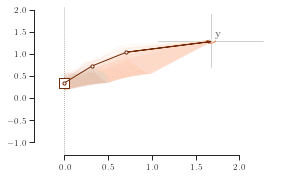

torch.Size([1000, 4])
---------------
****************


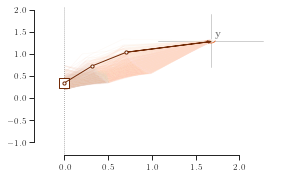

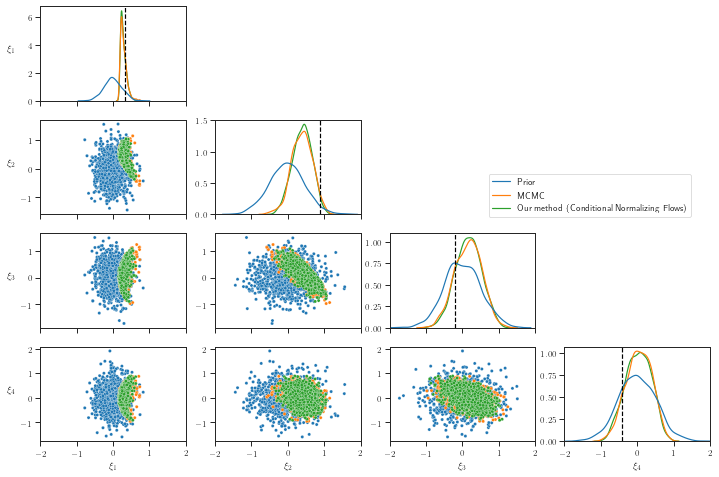

*****************************************************************************************************************************************************************************************
1
Groundtruth:
 xi_data=[[-0.22989541 -0.12536068  0.74884576  0.7099192 ]],
 y_data=[[1.1469465 0.9599577]]
torch.Size([1000, 4])
---------------
****************


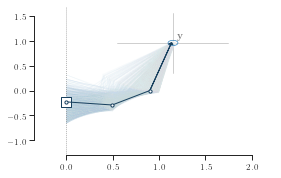

torch.Size([1000, 4])
---------------
****************


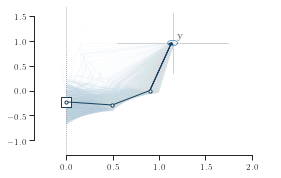

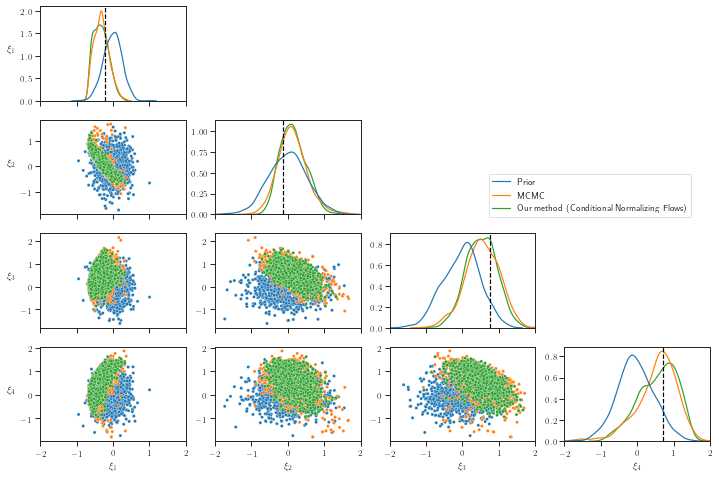

*****************************************************************************************************************************************************************************************
2
Groundtruth:
 xi_data=[[ 0.07322151 -0.12848109 -0.4071268   0.5861429 ]],
 y_data=[[ 1.92636    -0.18569945]]
torch.Size([1000, 4])
---------------
****************


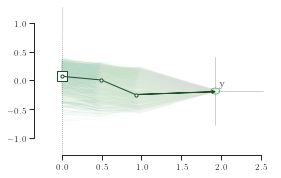

torch.Size([1000, 4])
---------------
****************


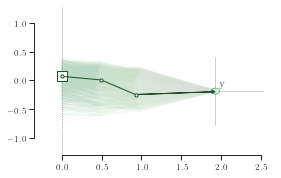

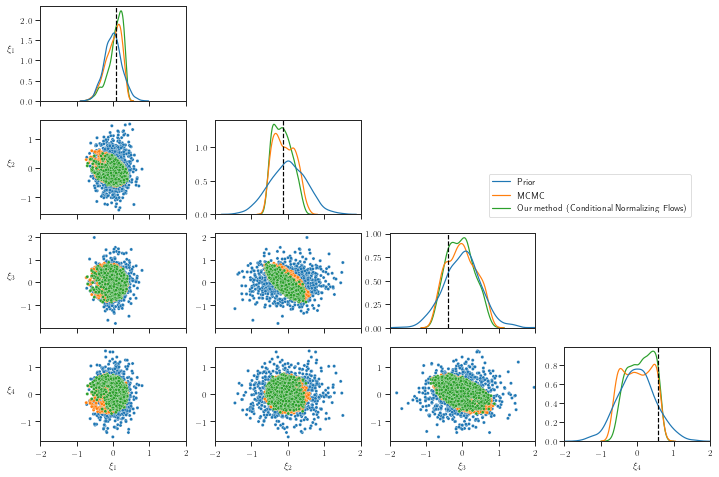

*****************************************************************************************************************************************************************************************
3
Groundtruth:
 xi_data=[[ 0.03473756  0.33038324 -0.00806682 -0.9201538 ]],
 y_data=[[ 1.7687088  -0.20761617]]
torch.Size([1000, 4])
---------------
****************


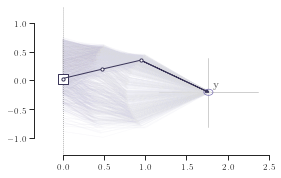

torch.Size([1000, 4])
---------------
****************


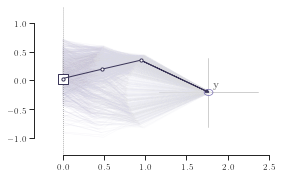

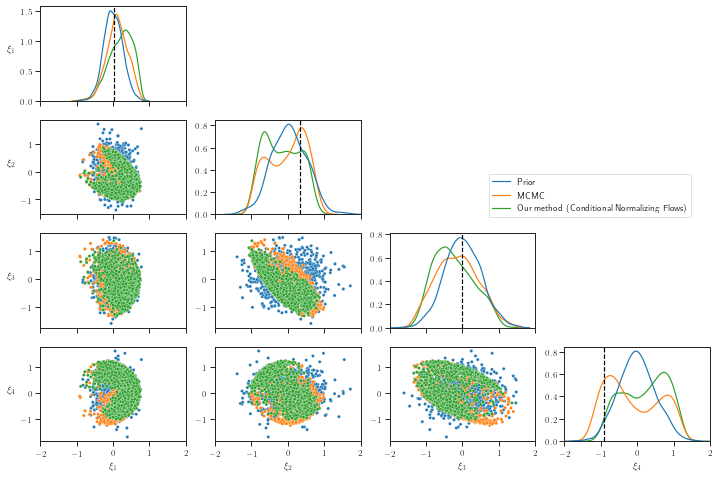

*****************************************************************************************************************************************************************************************
4
Groundtruth:
 xi_data=[[ 0.03867042  0.7878777  -0.4591129  -0.95894504]],
 y_data=[[ 1.6315098  -0.04351047]]
torch.Size([1000, 4])
---------------
****************


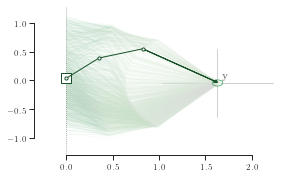

torch.Size([1000, 4])
---------------
****************


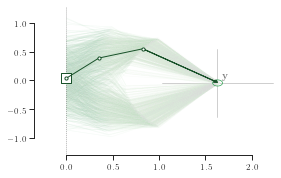

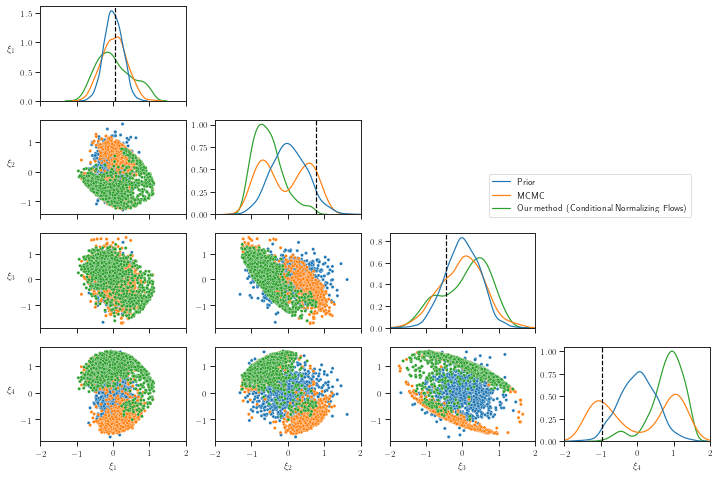

*****************************************************************************************************************************************************************************************


In [7]:
n_samples = 1000 # number of posterior samples

colorlist = [1,0,2,3,2]

for j in range(5):
    print(j)
    
    # Getting data
    xi_data, y_data = xi_data_[j].reshape(1,-1), y_data_[j].reshape(1,-1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))
    
    # color selection for plotting
    prior=False
    if prior:
        color_code = 4
    else:
        color_code = colorlist[j] #j+1 #random.randint(0, 3)

    # print(str(j)+'_AVI')
    # AVI_Conditional-Normalizing-Flows
    xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    print(xi_samples_AVI.shape)
    plot(xi_samples_AVI, xi_data, y_data, str(j)+'_AVI', "Our method (Conditional Normalizing Flows)", color_code)
    # print('-'*90)

    # print(str(j)+'_MCMC')
    # MCMC
    xi_samples_MCMC = torch.load(results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
    print(xi_samples_MCMC.shape)
    plot(xi_samples_MCMC, xi_data, y_data, str(j)+'_MCMC', "MCMC (NUTS)", color_code)
    # print('-'*90) 

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]  

    MCMC_data = xi_samples_MCMC.T.data.numpy()
    MCMC_dict = dict() 
    for i in range(MCMC_data.shape[0]):
        MCMC_dict[r'$\xi_{%.0f}$' % (i+1)] = MCMC_data[i]    

    df_Prior = pd.DataFrame(Prior_dict)
    df_MCMC = pd.DataFrame(MCMC_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_MCMC['Sample type'] = 'MCMC'
    df_AVI['Sample type'] = 'Our method (Conditional Normalizing Flows)'

    df = pd.concat([df_Prior, df_MCMC, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######   
    
    print('*'*185)  